In [ ]:
# THIS FILE INCLUDES ALL FUNCTIONL COMPONENTS INVOLVED IN 
# THE TOOL PRESENTED BY THE THESIS WITH SOME EXAMPLE OUTPUTS

In [1]:
# Required imports
import numpy as np # imports numpy
import matplotlib.pyplot as plt # imports matplotlib
from numba import jit # imports Numba
from geometry import * # imports the geometry file
from materials import * # imports the materials file
from inputs import * # imports the inputs file

In [2]:
# This function returns an r-grid (4D for anisotropy) given an input temperature grid. This input is needed
# to accound for materials with temperature-dependent thermal conductivities. This is discusses
# in section 2.2.1 of the thesis
def alphas(T):
    grid = np.zeros((gridx,gridy,gridz,3)) # establishes r-grid
    
    # updates r-values for carbon foam
    grid[foamx[0]:foamx[1],foamy[0]:foamy[1],foamz[0]:foamz[1],0:3] = r_cfo
    
    # updates x, y, and, z conductivities for carbon fiber
    grid[fiberx[0]:fiberx[1],fibery[0]:fibery[1],fiberz[0]:fiberz[1],0:1] = r_cfi[0]
    grid[fiberx[0]:fiberx[1],fibery[0]:fibery[1],fiberz[0]:fiberz[1],1:2] = r_cfi[1]
    grid[fiberx[0]:fiberx[1],fibery[0]:fibery[1],fiberz[0]:fiberz[1],2:3] = r_cfi[2]
    
    # uncomment the line below to replace the carbon fiber under the module with aluminum nitride
    #grid[inx[0]:inx[1],iny[0]:iny[1],fiberz[0]:fiberz[1],0:3] = r_aln
    
    # updates r-values in input layers
    for i in range(int(len(thicks))):
        grid[inx[0]:inx[1],iny[0]:iny[1],inz[0]+sum(thicks[0:i]):inz[0]+sum(thicks[0:i+1]),0:3] = r_ins[i]    
        
    # updates r-values in glass
    for i in range(glassx[0],glassx[1]):
        for j in range(glassy[0],glassy[1]):
            for k in range(glassz[0],glassz[1]):
                grid[i][j][k] = r_glass_T(T[i][j][k])
                
    # updates r-values in silicon
    for i in range(six[0],six[1]):
        for j in range(siy[0],siy[1]):
            for k in range(siz[0],siz[1]):
                grid[i][j][k] = r_si_T(T[i][j][k])
    return grid

In [3]:
# This function takes in a temperature grid representing the temperature
# of an entire assembly. It returns this temperature grid with all pixels in locations
# representing the tube updated to reflect the tubing temperature
# In other words, this function keeps the tubing temperatures constant at every iteration
@jit(nopython=True) # update shape in rectangular prism form
def Tupdatetube(T):
    Tn = T
    for l in list(range(ctb1x-tr, ctb1x+tr+1)) + list(range(ctb2x-tr, ctb2x+tr+1)): # loop over possible x-values of tube
        for m in range(ctbz-tr,ctbz+tr+1): # loop over possible z-values of tube
            if (min((l-ctb1x)**2,(l-ctb2x)**2)+(m-ctbz)**2 <= tr**2): # if the pixel is in either tube
                Tn[l:l+1,0:T.shape[1]-1,m:m+1]=tt # set temperature to tube temperature   
    return Tn

In [4]:
# This function initializes the temperature grid for the entire assembly.
# Is has no inputs as relevane parameters are in the imported files
def Tinit(): # creates a grid with features of heat source and cold tube points    
    grid = at*np.ones((gridx,gridy,gridz)) # establish grid    
    grid = Tupdatetube(grid) # initialize tubing temperatures
    return grid

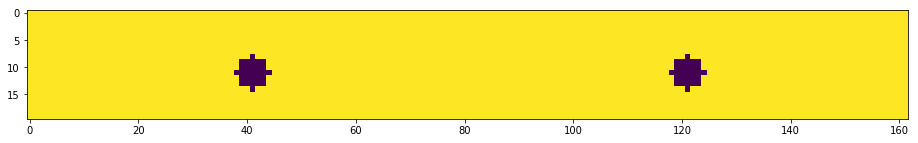

In [5]:
# shows an x-y cross section of the inital temperature grid (cooling tubes are in blue)
TCS = Tinit()
plt.figure(figsize = (20,2))
plt.imshow(np.flipud(np.transpose(TCS[:,16,:])))

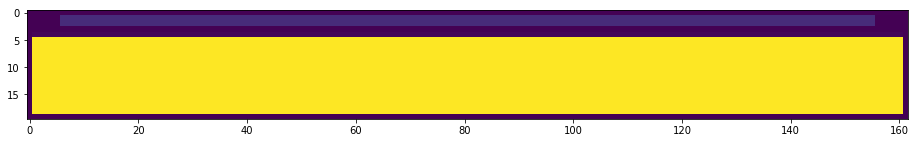

In [6]:
# shows an x-y cross section of the inital r grid's x-conductivity (x-conductivity because of anisotropy)
RCS = alphas(Tinit())
plt.figure(figsize = (20,2))
plt.imshow(np.flipud(np.transpose(RCS[:,16,:,0])))

In [7]:
# This function takes in a T-grid (a 3D pixel-grid with a temperature for each pixel)
# and an r-grid (a 3D pixel-grid with an r-value for each pixel) and a set of three
# coordinates of a "focus" pixel
# and returns the new temperature of the "focus" pixel after one time-step calculated 
# equation 2.16 of the thesis
@jit(nopython=True)
def wavg(T, r, i1, i2, i3):
    return T[i1][i2][i3]+r[i1+1][i2][i3][0]*(T[i1+1][i2][i3]-T[i1][i2][i3])\
                        +r[i1-1][i2][i3][0]*(T[i1-1][i2][i3]-T[i1][i2][i3])\
                        +r[i1][i2+1][i3][1]*(T[i1][i2+1][i3]-T[i1][i2][i3])\
                        +r[i1][i2-1][i3][1]*(T[i1][i2-1][i3]-T[i1][i2][i3])\
                        +r[i1][i2][i3+1][2]*(T[i1][i2][i3+1]-T[i1][i2][i3])\
                        +r[i1][i2][i3-1][2]*(T[i1][i2][i3-1]-T[i1][i2][i3])

In [8]:
# This function takes in a T-grid (a 3D pixel-grid with a temperature for each pixel)
# and an r-grid (a 3D pixel-grid with an r-value for each pixel) (rectangular prisms) and three
# pairs of coordinates establishing the limits of this priem along the three dimensions (in pixels)
# of a rectangular prism. It also includes h parameter defined in euation 2.18 to indicate
# heat added to every pixel for one time iteration.
# The function returns the updated temperature proile of this
# rectangular prism after one time-step
@jit(nopython=True) # update shape in rectangular prism form
def Tupdaterectp(T, r, x0, x1, y0, y1, z0, z1, p):
    Tn = T
    for i in range(x0,x1):
        for j in range(y0,y1):
            for k in range(z0,z1):
                Tn[i][j][k] = wavg(T, r, i, j, k)+p  
    return Tn

In [9]:
# This function takes in a T-grid (a 3D pixel-grid with a temperature for each pixel)
# and an r-grid (a 3D pixel-grid with an r-value for each pixel) representing the 
# entire simulated assembly. It also takes in a parameter pin representing the total input power
# The function returns the updated temperature proile of the entire simulated assembly for one time step
@jit(nopython=True)
def Tupdate(T, r, pin): 
    Tn = T
    Tn = Tupdaterectp(T, r, 1, T.shape[0]-1, 1, T.shape[1]-1, foamz0, foamz1, 0) # updates foam temperature
    Tn = Tupdaterectp(T, r, 1, T.shape[0]-1, 1, T.shape[1]-1, fiberz0, fiberz1, 0) # updates fiber temperature
    Tn = Tupdaterectp(T, r, inx0, inx1, iny0, iny1, inz0, inz1, 0) # update the input layer temperatures
    Tn = Tupdaterectp(T, r, inx0, inx1, iny0, iny1, glassz0, glassz1, 0) # update the glass temperaures
    Tn = Tupdaterectp(T, r, inx0, inx1, iny0, iny1-hsw, siz0, siz1, (1-mpsr)*pin*vmod/(vmod-vshunt)) # update the module temp.
    Tn = Tupdaterectp(T, r, inx0, inx1, iny1-hsw, iny1, siz0, siz1, mpsr*pin*vmod/vshunt) # update the module shunt temp.
    Tn = Tupdatetube(T) # keeps the tubes at a constant temperature
    return Tn

In [10]:
# this function displays a progress bar under simulations
def progressBar(current, total, barLength = 20):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))
    print('Progress: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')

In [11]:
# This function creates a plot of average silicon temperature over time
# for some total input time 'stime' in seconds, some r-grid update frequency
# time 'rupdatef' in seconds, and some total power to the module 'ptot'
# it displays a progress bar by default
def avgsitemptime(stime, rupdatef, ptot):
    eadd = dt*ptot/(deltad**3*vmod)
    pai = eadd/(dens_si*cp_si)
    tlen = int(np.floor(stime/dt))
    T = Tinit()
    A = alphas(T)
    timeseries = np.zeros(tlen)
    for h in range(tlen):
        timeseries[h]=np.mean(T[six[0]:six[1],siy[0]:siy[1],siz[0]:siz[1]])
        T = Tupdate(T, A, pai)
        if np.mod(h,np.floor(rupdatef/dt)) == 0:
            A = alphas(T)
        progressBar(h+1, tlen)    
    x = np.linspace(0,tlen*dt,tlen)
    plt.plot(x,timeseries)
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.show()

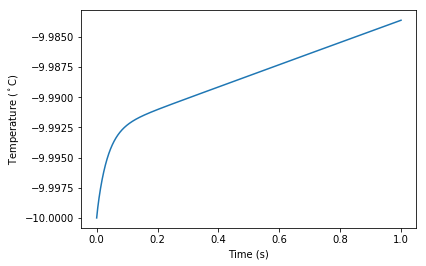

In [12]:
avgsitemptime(1, 0.05, 0.2)

In [13]:
# This function, for some total input time 'stime' in seconds, some r-grid update frequency
# time 'rupdatef' in seconds, and some total power to the module 'ptot,' returns the
# slope of the average silicon temperature plot over time at the final time
# as discussed in Section 4.2 of the thesis, this is an important metric for performance evaluation
# this includes a commented-out progress bar
def final_diff(stime, rupdatef, ptot):
    eadd = dt*ptot/(deltad**3*vmod)
    pai = eadd/(dens_si*cp_si)
    tlen = int(np.floor(stime/dt))
    T = Tinit()
    A = alphas(T)
    timeseries = np.zeros(tlen)
    for h in range(tlen):
        timeseries[h]=np.mean(T[six[0]:six[1],siy[0]:siy[1],siz[0]:siz[1]])
        T = Tupdate(T, A, pai)
        if np.mod(h,np.floor(rupdatef/dt)) == 0:
            A = alphas(T)
        #progressBar(h+1, tlen)
    return (timeseries[-1]-timeseries[-2])/dt

In [14]:
# This function implements the bisection method used to find some the critical power
# corresponding to a particular design as discussed in section 4.2 of the thesis
# it takes in a known under-powered power level 'minp' (which can safely be zero)
# and a known over-powered power level 'maxp' (which can be large or refined using 
# the above plotting function avgsitemptime() )
# it also takes in total input time 'stime' in seconds for which simulations are run
# and some r-grid update frequency time 'rupdatef' in seconds
# it finally takes in 'nit' which is the number of iterations fot which it is run
# For every iteration, the function prints out a closed set within-which it assesses the
# root to be located. After the number of iteration is surpassed, it outputs its 
# best guess at the true root (the midpoitn between the last established range)
# a progress bar can be shown for every iteration if uncommented from final_diff()
def bisection_power_search(minp, maxp, stime, rupdatef, nit):
    for i in range(nit):
        initmid = np.mean([minp,maxp])
        print([minp,maxp])
        cand = np.round(final_diff(stime, rupdatef, initmid),5) 
        if cand < 0:
            minp = initmid
        elif cand > 0:
            maxp = initmid
        else:
            break
    return initmid

In [15]:
bisection_power_search(0.18, 0.20, 0.2, 0.05, 8)

[0.18, 0.2]
[0.19, 0.2]
[0.19, 0.195]
[0.19, 0.1925]
[0.19125, 0.1925]
[0.19187500000000002, 0.1925]
[0.1921875, 0.1925]
[0.19234375, 0.1925]


0.19242187500000002